In [30]:
import pathlib
import os

root_dir = '/Users/ninast/Desktop/Whole_genome_analysis/enterococcus/'
json_paths = list(pathlib.Path(root_dir + 'resfinder_results_extra').glob('*/data_resfinder.json'))
print(len(list(json_paths)))

26


In [31]:
import json

with open(json_paths[0], 'r') as f:
    raw_json = json.load(f)
    print(json.dumps(raw_json, indent=2))

{
  "resfinder": {
    "user_input": {
      "filename(s)": [
        "extra_data/V1034_S14_L001_R1_001.fastq",
        "extra_data/V1034_S14_L001_R2_001.fastq"
      ],
      "method": "kma",
      "file_format": "fastq"
    },
    "run_info": {
      "date": "30.04.2020",
      "time": "09:06:08"
    },
    "results": {
      "Aminoglycoside": {
        "aminoglycoside": {
          "aac(6')-Ii_1_L12710": {
            "resistance_gene": "aac(6')-Ii",
            "identity": 99.64,
            "HSP_length": 549,
            "template_length": 549,
            "position_in_ref": "1..550",
            "contig_name": "NA",
            "positions_in_contig": "NA..NA",
            "note": "1",
            "accession": "L12710",
            "predicted_phenotype": "Warning: gene is missing from Notes file. Please inform curator.",
            "coverage": 100.0,
            "hit_id": "aac(6')-Ii_1_L12710",
            "subject_header": "aac(6')-Ii_1_L12710"
          }
        }
      },
   

In [32]:
import pandas as pd 

jsons = [json.load(open(path, 'r'))['resfinder'] for path in json_paths]
df = pd.json_normalize(jsons)

In [33]:
data = []
type_for_gene_name = {}
for path in json_paths:
    with open(path, 'r') as f:
        raw_json = json.load(f)
        
    stripped_result = {} 
    name = pathlib.Path(raw_json['resfinder']['user_input']["filename(s)"][0]).name
    stripped_result['name'] = name
    # sample_type_hospital = get_sample_type_and_hospital_for_name(name) 
    # stripped_result['sample_type'] = sample_type_hospital[0]
    # stripped_result['hospital'] = sample_type_hospital[1]

    results_json = raw_json['resfinder']['results']
    for db_json in results_json.values():
        for gene_type, genes in db_json.items():
            if isinstance(genes, dict):
                for x in genes.keys():
                    stripped_name = x.rsplit('_', 1)[0]
                    stripped_result[stripped_name] = 1
                    type_for_gene_name[stripped_name] = gene_type
    
    data.append(stripped_result)

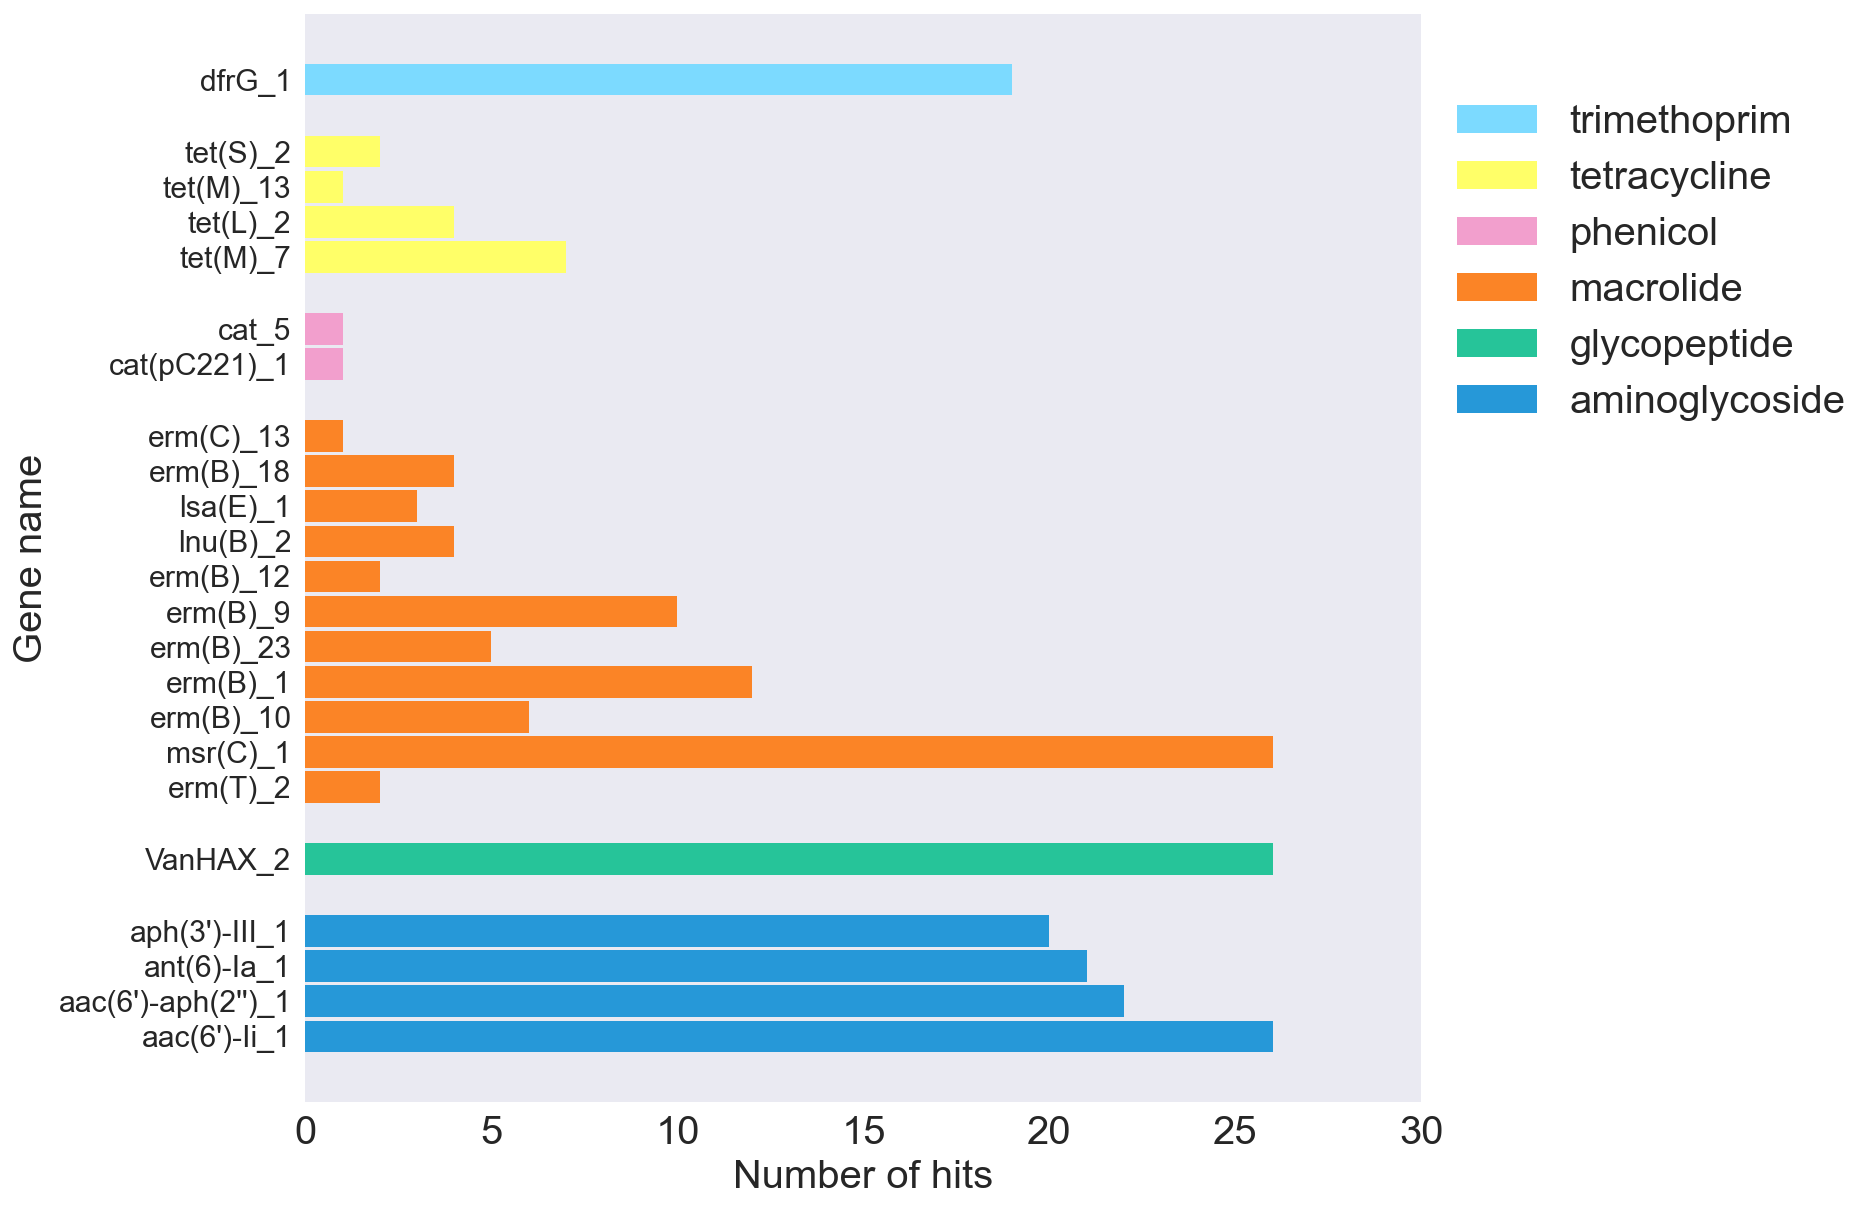

In [51]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-colorblind')

%config InlineBackend.figure_format = 'retina'

df = pd.DataFrame(data)
df_t = df.transpose().drop('name')
df_t['gene_type'] = df_t.index.map(type_for_gene_name)
df_t = df_t.reset_index()
df_t.set_index(['gene_type', 'index'], inplace=True)
df_t = df_t.sum(1)

groups = df_t.index.levels[0].tolist()

margin = 0.05
distance_between_groups = 2
current_pos = 0

fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)

all_positions = []
all_labels = []
for num, group_name in enumerate(groups):
    df_group = df_t.groupby(level=0).get_group(group_name).unstack()
    df_group_t = df_group.transpose()

    group_values = df_group.values.tolist()
    group_values = [item for sublist in group_values for item in sublist]

    xdata = np.arange(current_pos + margin, current_pos + len(group_values)) 
    current_pos = xdata[-1] + distance_between_groups

    group_labels = df_group_t.index.tolist()

    all_positions.extend(xdata)
    all_labels.extend(group_labels)
    
    bplot = ax.barh(xdata, group_values, height=0.9, label=group_name, align='center')
    for bplot_i in bplot:
        color = bplot_i.get_facecolor()
        color = [min(x + 0.15, 1.0) for x in color]
        bplot_i.set_facecolor(color)
    
plt.xlabel('Number of hits', size=20)
plt.ylabel('Gene name', size=20)
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1],bbox_to_anchor=(1.0, 0.95), prop={"size":20})

ax.set_xlim((0, 30))
ax.tick_params(axis='both', which='major', labelsize=20)

ax.set_yticks(all_positions)
ax.set_yticklabels(all_labels, size=15);
ax.grid(False)

plt.savefig('extra_histogram.png', bbox_inches='tight')
